In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
DATASET_PATH = "/content/drive/MyDrive/Age_and_Gender_Prediction/UTKFace"

# Verify dataset exists
if os.path.exists(DATASET_PATH):
    print("Dataset found:", len(os.listdir(DATASET_PATH)), "images")
else:
    print("Dataset not found. Check path.")

Dataset found: 23708 images


In [25]:
# STEP 2 — Parse filenames and create dataset list

import os
import pandas as pd

#Replace with your verified dataset path
DATASET_PATH = "/content/drive/MyDrive/Age_and_Gender_Prediction/UTKFace"

# Get all image file names
image_files = [f for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Total images found: {len(image_files)}")

# Function to extract age and gender from filename
def parse_filename(filename):
    try:
        parts = filename.split('_')
        age = int(parts[0])
        gender = int(parts[1])
        return age, gender
    except:
        return None, None

# Create a list of tuples (path, age, gender)
data_records = []
for img in image_files:
    age, gender = parse_filename(img)
    if age is not None and gender in [0, 1]:  # only keep valid ones
        full_path = os.path.join(DATASET_PATH, img)
        data_records.append((full_path, age, gender))

print(f"Successfully parsed {len(data_records)} valid records.")

# Create DataFrame for convenience
df = pd.DataFrame(data_records, columns=["path", "age", "gender"])
df.head()

Total images found: 23708
Successfully parsed 23708 valid records.


,path,age,gender
0,/content/drive/MyDrive/Age_and_Gender_Predicti...,81,1
1,/content/drive/MyDrive/Age_and_Gender_Predicti...,9,0
2,/content/drive/MyDrive/Age_and_Gender_Predicti...,8,0
3,/content/drive/MyDrive/Age_and_Gender_Predicti...,9,1
4,/content/drive/MyDrive/Age_and_Gender_Predicti...,80,1


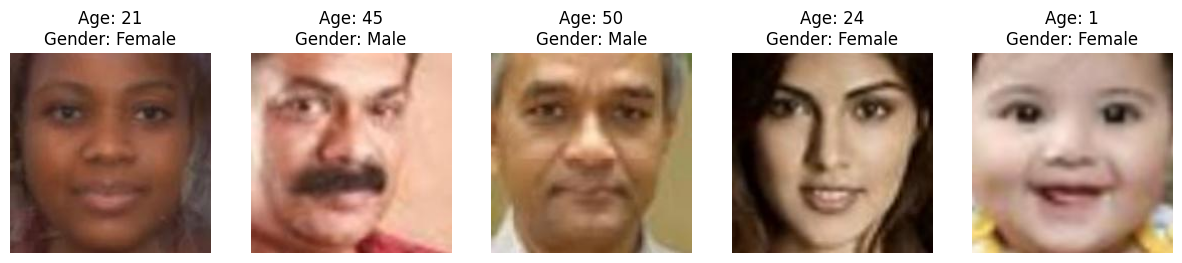

In [26]:
# STEP 3 — Visualize random images with age/gender labels

import cv2
import matplotlib.pyplot as plt
import random

samples = random.sample(df.values.tolist(), 5)

plt.figure(figsize=(15, 3))
for i, (path, age, gender) in enumerate(samples):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    g = "Male" if gender == 0 else "Female"
    plt.title(f"Age: {age}\nGender: {g}")
    plt.axis('off')

plt.show()

In [28]:
# Cell A1 — imports & config
import os, random, math, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Paths (adjust if needed)
DATASET_PATH = "/content/drive/MyDrive/Age_and_Gender_Prediction/UTKFace"
MODEL_DIR = "/content/drive/MyDrive/Age_and_Gender_Prediction/Model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Hyperparams
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 3e-4   # slightly higher to escape plateaus
print("Config:", IMG_SIZE, BATCH_SIZE, EPOCHS, INITIAL_LR)

Config: 128 32 60 0.0003


In [31]:
# Cell A2 — build train/val datasets (light augmentation)
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import layers

# Build df (if not already in workspace)
image_files = [f for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.jpg','.jpeg','.png'))]
records=[]
for f in image_files:
    try:
        parts = f.split('_')
        age = int(parts[0]); gender = int(parts[1])
        records.append((os.path.join(DATASET_PATH,f), age, gender))
    except:
        pass
df = pd.DataFrame(records, columns=['path','age','gender'])
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print("Train:", len(train_df), "Val:", len(val_df))

# Light augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomBrightness(0.04),
    layers.RandomContrast(0.04)
])

def preprocess(path, age, gender, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    if augment:
        img = data_augmentation(img)

    # ✅ Explicitly cast age and gender to float32 first
    age = tf.cast(age, tf.float32)
    gender = tf.cast(gender, tf.float32)

    return img, {
        "age_out": age / 100.0,   # normalize after casting
        "gender_out": gender
    }

def make_ds(df_input, training=False):
    paths = df_input['path'].values
    ages = df_input['age'].values
    genders = df_input['gender'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders))
    ds = ds.map(lambda p,a,g: preprocess(p,a,g,augment=training), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(2048)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds = make_ds(val_df, training=False)
print("Datasets ready.")

Train: 18966 Val: 4742
Datasets ready.


In [32]:
# Cell A3 — custom CNN with separate age & gender branches

def conv_block(x, filters, kernel=3, pool=True):
    x = layers.Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if pool:
        x = layers.MaxPool2D()(x)
    return x

def build_custom_cnn(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    inp = Input(shape=input_shape, name='image')
    x = conv_block(inp, 32)    # 128 -> 64
    x = conv_block(x, 64)      # 64 -> 32
    x = conv_block(x, 128)     # 32 -> 16
    x = conv_block(x, 256)     # 16 -> 8
    x = conv_block(x, 512)     # 8 -> 4
    x = layers.GlobalAveragePooling2D()(x)

    # Age branch (regression)
    a = layers.Dense(256, activation='relu')(x)
    a = layers.Dropout(0.35)(a)
    age_out = layers.Dense(1, activation='linear', name='age_out')(a)

    # Gender branch (classification)
    g = layers.Dense(256, activation='relu')(x)
    g = layers.Dropout(0.35)(g)
    gender_out = layers.Dense(1, activation='sigmoid', name='gender_out')(g)

    return Model(inputs=inp, outputs=[age_out, gender_out], name='custom_age_gender')

model = build_custom_cnn()
model.summary()

Model: "custom_age_gender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │        896 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ re_lu_10[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ re_lu_11[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ re_lu_12[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_12… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 256) │          0 │ re_lu_13[0][0]  

 Total params: 1,835,714 (7.00 MB)

 Trainable params: 1,833,730 (7.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [33]:
# Cell A4 — compile with Huber loss and Adam optimizer
from tensorflow.keras.losses import Huber

opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)
losses = {"age_out": Huber(delta=0.1), "gender_out": "binary_crossentropy"}
metrics = {"age_out":["mae"], "gender_out":["accuracy"]}

model.compile(optimizer=opt, loss=losses, metrics=metrics)
print("Compiled.")

Compiled.


In [35]:
# ✅ Fixed callbacks for EarlyStopping
ckpt = ModelCheckpoint(
    os.path.join(MODEL_DIR, "best_custom.keras"),
    monitor="val_age_out_mae",
    save_best_only=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor="val_age_out_mae",
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

es = EarlyStopping(
    monitor="val_age_out_mae",
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='min'   # ✅ explicitly tell Keras that lower MAE is better
)

# retrain
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, rlr, es],
    verbose=1
)

# save final
model.save(os.path.join(MODEL_DIR, "final_custom.keras"))
print("Training finished and model saved.")

Epoch 1/60
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - age_out_loss: 0.0115 - age_out_mae: 0.1566 - gender_out_accuracy: 0.5174 - gender_out_loss: 0.6928 - loss: 0.7043
Epoch 1: val_age_out_mae improved from inf to 0.14837, saving model to /content/drive/MyDrive/Age_and_Gender_Prediction/Model/best_custom.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - age_out_loss: 0.0115 - age_out_mae: 0.1566 - gender_out_accuracy: 0.5174 - gender_out_loss: 0.6928 - loss: 0.7043 - val_age_out_loss: 0.0108 - val_age_out_mae: 0.1484 - val_gender_out_accuracy: 0.5285 - val_gender_out_loss: 0.6907 - val_loss: 0.7015 - learning_rate: 3.0000e-04
Epoch 2/60
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - age_out_loss: 0.0116 - age_out_mae: 0.1571 - gender_out_accuracy: 0.5231 - gender_out_loss: 0.6927 - loss: 0.7042
Epoch 2: val_age_out_mae did not improve from 0.14837
593/593 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - age_out_loss: 0.0116 - age_out_mae: 0.1571 - gender_out_accuracy: 0.5231 - gender_out_loss: 0.69

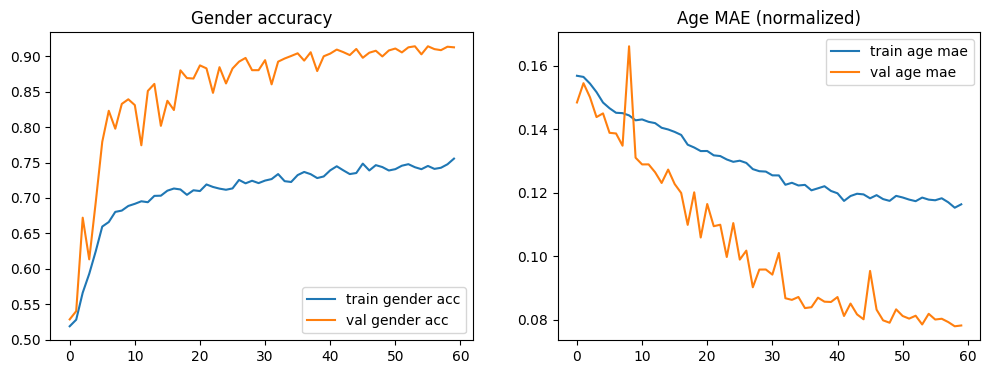

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - age_out_loss: 0.0043 - age_out_mae: 0.0791 - gender_out_accuracy: 0.9169 - gender_out_loss: 0.2126 - loss: 0.2170
loss: 0.2160
compile_metrics: 0.0043
age_out_loss: 0.2109
gender_out_loss: 0.0779


In [36]:
# Cell A6 — plot curves and eval
h = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(h.get('gender_out_accuracy', []), label='train gender acc')
plt.plot(h.get('val_gender_out_accuracy', []), label='val gender acc')
plt.legend(); plt.title('Gender accuracy')

plt.subplot(1,2,2)
plt.plot(h.get('age_out_mae', []), label='train age mae')
plt.plot(h.get('val_age_out_mae', []), label='val age mae')
plt.legend(); plt.title('Age MAE (normalized)')

plt.show()

# Final numeric evaluation
res = model.evaluate(val_ds, verbose=1)
for name, val in zip(model.metrics_names, res):
    print(f"{name}: {val:.4f}")

In [38]:
# Cell A7 — inspect preds on 20 val samples
import pandas as pd
rows=[]
for batch in val_ds.take(10):  # up to 10 batches
    imgs, labels = batch
    true_ages = labels['age_out'].numpy().flatten() * 100
    true_genders = labels['gender_out'].numpy().flatten()
    pred_ages_norm, pred_genders = model.predict(imgs, verbose=0)
    pred_ages = pred_ages_norm.flatten() * 100
    pred_gender_probs = pred_genders.flatten()
    for ta, pa, tg, pg in zip(true_ages, pred_ages, true_genders, pred_gender_probs):
        rows.append((round(float(ta),1), round(float(pa),1), int(tg), round(float(pg),3)))
    if len(rows) >= 20: break

df_preds = pd.DataFrame(rows[:20], columns=['true_age','pred_age','true_gender','pred_male_prob'])
print(df_preds)

    true_age  pred_age  true_gender  pred_male_prob
0       26.0      28.6            0           0.001
1       66.0      69.8            1           0.994
2       65.0      73.7            0           0.002
3       37.0      36.1            0           0.000
4       45.0      56.8            0           0.001
5       27.0      24.0            1           0.995
6       47.0      41.9            0           0.000
7       28.0      24.6            1           0.983
8       39.0      25.4            1           0.985
9        5.0      18.6            0           0.931
10       1.0       7.1            0           0.348
11       3.0       9.8            1           0.176
12      15.0      27.8            1           0.999
13      75.0      89.9            0           0.761
14      36.0      43.2            1           0.997
15      62.0      42.3            0           0.000
16       2.0      15.3            0           0.247
17       5.0      14.5            1           0.902
18      30.0

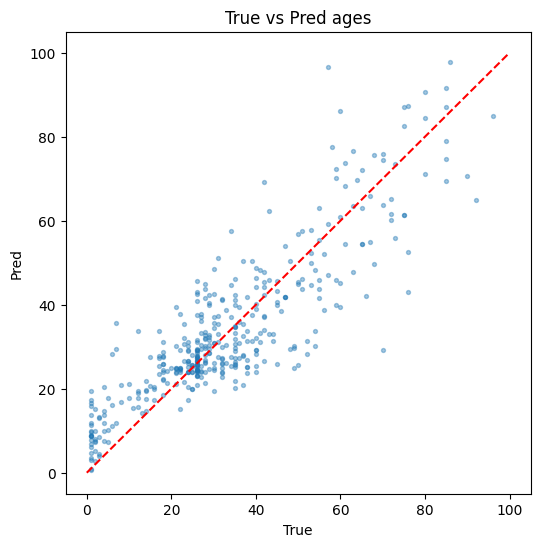

In [39]:
# Cell A8 — scatter plot 400 random val samples
import random
sample = val_df.sample(min(400, len(val_df))).values.tolist()
y_true=[]; y_pred=[]
for path, age, gender in sample:
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255.0
    pred_a, pred_g = model.predict(tf.expand_dims(img,0), verbose=0)
    y_true.append(age)
    y_pred.append(float(pred_a[0][0]*100))
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4, s=8)
plt.plot([0,100],[0,100],'r--'); plt.xlabel('True'); plt.ylabel('Pred'); plt.title('True vs Pred ages')
plt.show()

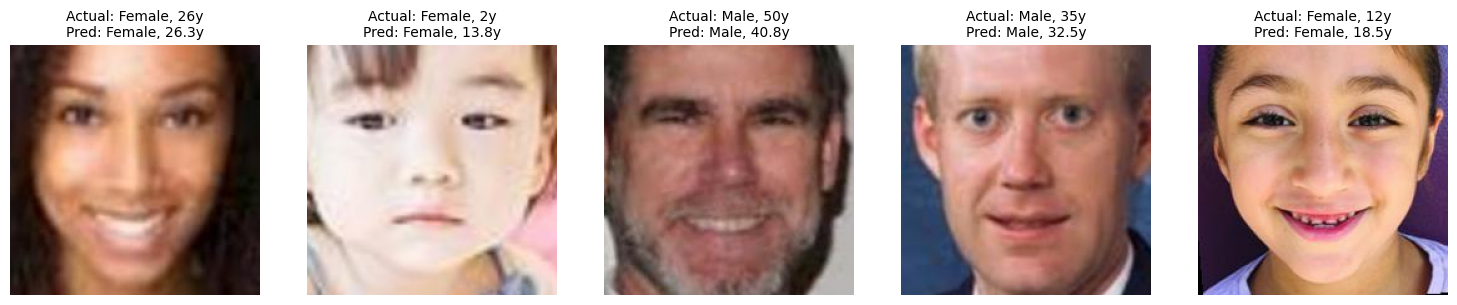

In [40]:
# ✅ Visualize Actual vs Predicted Age & Gender
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

# pick random 5 validation samples
samples = random.sample(val_df.values.tolist(), 5)

plt.figure(figsize=(15, 3))
for i, (path, true_age, true_gender) in enumerate(samples):
    # read and preprocess image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    # run model prediction
    pred_age_norm, pred_gender = model.predict(np.expand_dims(resized, 0), verbose=0)
    pred_age = float(pred_age_norm[0][0] * 100.0)
    pred_gender_label = "Female" if pred_gender[0][0] > 0.5 else "Male"

    # true labels
    true_gender_label = "Female" if true_gender == 1 else "Male"

    # plot image and labels
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Actual: {true_gender_label}, {int(true_age)}y\n"
        f"Pred: {pred_gender_label}, {pred_age:.1f}y",
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [41]:
# Step F1 — Fine-tuning setup (smaller delta, lower LR)
from tensorflow.keras.losses import Huber

FINE_TUNE_LR = 1e-4  # smaller learning rate for fine tuning
FINE_TUNE_DELTA = 0.05  # tighter tolerance for age regression

# Re-compile model with sharper Huber loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss={
        "age_out": Huber(delta=FINE_TUNE_DELTA),
        "gender_out": "binary_crossentropy"
    },
    metrics={
        "age_out": ["mae"],
        "gender_out": ["accuracy"]
    }
)

print("Model recompiled with Huber(δ=0.05) and LR =", FINE_TUNE_LR)

Model recompiled with Huber(δ=0.05) and LR = 0.0001


In [42]:
# Step F2 — Continue fine-tuning
fine_tune_epochs = 15  # or 20 if you want to let it settle
start_epoch = len(history.epoch)

print(f"Resuming training from epoch {start_epoch} for {fine_tune_epochs} more epochs...")

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=start_epoch,
    epochs=start_epoch + fine_tune_epochs,
    callbacks=[ckpt, rlr, es],
    verbose=1
)

print("Fine-tuning complete.")

Resuming training from epoch 60 for 15 more epochs...
Epoch 61/75
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - age_out_loss: 0.0049 - age_out_mae: 0.1192 - gender_out_accuracy: 0.7419 - gender_out_loss: 0.4154 - loss: 0.4203
Epoch 61: val_age_out_mae did not improve from 0.07792
593/593 ━━━━━━━━━━━━━━━━━━━━ 60s 82ms/step - age_out_loss: 0.0049 - age_out_mae: 0.1192 - gender_out_accuracy: 0.7419 - gender_out_loss: 0.4154 - loss: 0.4203 - val_age_out_loss: 0.0031 - val_age_out_mae: 0.0838 - val_gender_out_accuracy: 0.8633 - val_gender_out_loss: 0.3103 - val_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 62/75
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - age_out_loss: 0.0048 - age_out_mae: 0.1187 - gender_out_accuracy: 0.7447 - gender_out_loss: 0.4161 - loss: 0.4210
Epoch 62: val_age_out_mae did not improve from 0.07792
593/593 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - age_out_loss: 0.0048 - age_out_mae: 0.1187 - gender_out_accuracy: 0.7447 - gender_out_loss: 0.4161 - loss: 0.4210 - val_age_out_

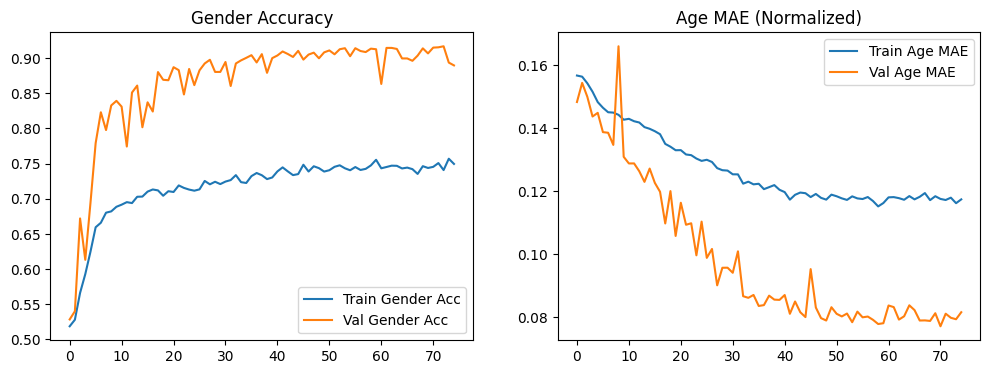

In [43]:
# Step F3 — Plot fine-tuned metrics
hist_combined = history.history.copy()
for k, v in history_fine.history.items():
    hist_combined[k] = hist_combined.get(k, []) + v

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_combined['gender_out_accuracy'], label='Train Gender Acc')
plt.plot(hist_combined['val_gender_out_accuracy'], label='Val Gender Acc')
plt.legend(); plt.title('Gender Accuracy')

plt.subplot(1,2,2)
plt.plot(hist_combined['age_out_mae'], label='Train Age MAE')
plt.plot(hist_combined['val_age_out_mae'], label='Val Age MAE')
plt.legend(); plt.title('Age MAE (Normalized)')
plt.show()

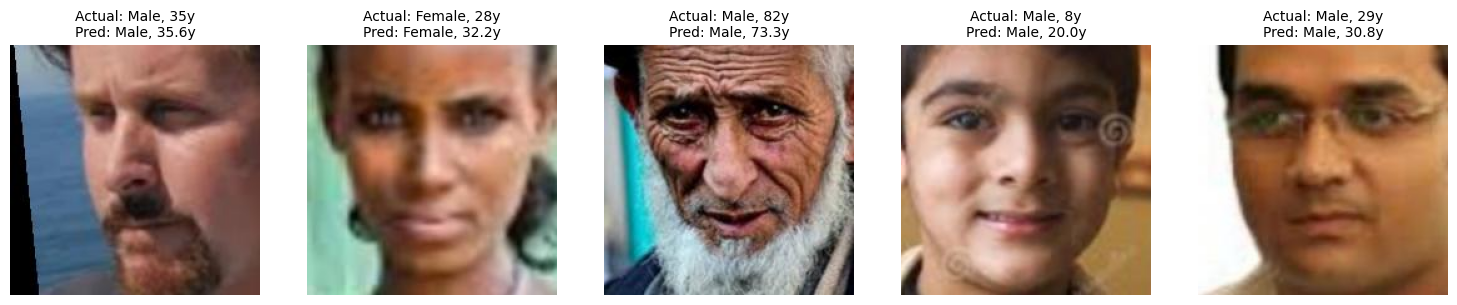

In [44]:
# Step F4 — Compare actual vs predicted again
import cv2, random, numpy as np, matplotlib.pyplot as plt

samples = random.sample(val_df.values.tolist(), 5)
plt.figure(figsize=(15, 3))
for i, (path, true_age, true_gender) in enumerate(samples):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    pred_age_norm, pred_gender = model.predict(np.expand_dims(resized, 0), verbose=0)
    pred_age = float(pred_age_norm[0][0] * 100.0)
    pred_gender_label = "Female" if pred_gender[0][0] > 0.5 else "Male"
    true_gender_label = "Female" if true_gender == 1 else "Male"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {true_gender_label}, {int(true_age)}y\nPred: {pred_gender_label}, {pred_age:.1f}y", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Step RT1 — Real-Time Age and Gender Prediction (Local Webcam)
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
MODEL_PATH = "/content/drive/MyDrive/Age_and_Gender_Prediction/Model_custom/final_custom.keras"
model = load_model(MODEL_PATH, compile=False)

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

IMG_SIZE = 128

# Gender map
gender_dict = {0: "Male", 1: "Female"}

# Start video capture
cap = cv2.VideoCapture(0)  # use 0 for default webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Crop & preprocess
        face_img = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE)) / 255.0
        face_input = np.expand_dims(face_resized, axis=0)

        # Predict
        pred_age_norm, pred_gender = model.predict(face_input, verbose=0)
        pred_age = float(pred_age_norm[0][0] * 100.0)
        pred_gender_label = "Female" if pred_gender[0][0] > 0.5 else "Male"

        # Draw results
        text = f"{pred_gender_label}, {int(pred_age)}y"
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
        cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 255), 2)

    cv2.imshow('Age & Gender Prediction', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()